In [1]:
from spectral_cube import SpectralCube #To read FITS
import numpy as np
import astropy.units as u
from astropy.coordinates import SkyCoord, Angle
from skimage import measure
from astropy import wcs
import cube_x3d as c3
import matplotlib.pyplot as plt
from matplotlib import cm
from astroquery.skyview import SkyView

In [3]:
import importlib
importlib.reload(c3)

<module 'cube_x3d' from 'c:\\Users\\ixaka\\Documents\\Visualization\\cube_x3d\\cube_x3d.py'>

In [2]:
%cd C:\Users\ixaka\Documents\Visualization

C:\Users\ixaka\Documents\Visualization


In [4]:
# Read the fits file and save header
HI_cube = SpectralCube.read("HCG16.fits")
cubehead = HI_cube.header
cubew = wcs.WCS(cubehead)
nz, ny, nx = HI_cube.shape
print(HI_cube.shape)
dra, ddec, dv = cubehead['CDELT1'], cubehead['CDELT2'], cubehead['CDELT3']
delta_arcsec = (np.abs(dra)*3600, np.abs(ddec)*3600, np.abs(dv)/1e3) # to arcsec and GHz
print(delta_arcsec)

(133, 280, 315)
(6.000000000012, 6.000000000012, 5.513421849239999)


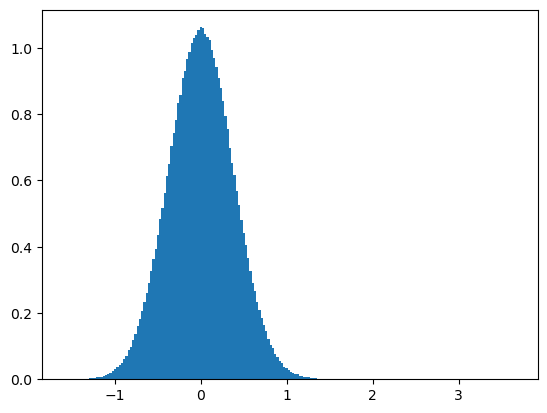

In [6]:
plt.hist(HI_cube.unmasked_data[:20].to_value().flatten()*1000, bins=200, density=True);

In [5]:
# calculate rms of data. choose an area with no emission
from scipy.stats import norm
_, rms = norm.fit(HI_cube.unmasked_data[:20].to_value().flatten()*1000)
print(rms)

0.38241458


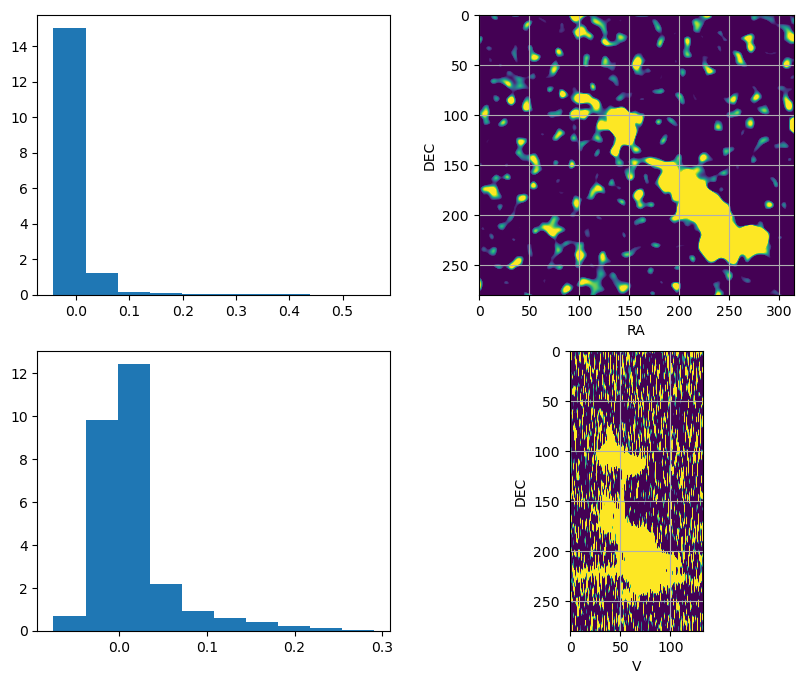

In [5]:
c3.preview2d(HI_cube.unmasked_data[:].to_value(), vmin1=0.008, vmax1=0.02, vmin2=0.008, vmax2=0.02, norm='asinh')

In [ ]:
limx = [0, nx-1]
limy = [0, ny-1]
limz = [0, nz-1]

In [5]:
#HCG31
# Limits to crop the cube, no HI there. Subtract 1 to wanted number, e.g. nz-1.
limx = [60, nx-61]
limy = [100, ny-91]
limz = [90, nz-81]

In [6]:
#HCG16
# Limits to crop the cube, no HI there. Subtract 1 to wanted number, e.g. nz-1.
limx = [80, nx-16]
limy = [50, ny-11]
limz = [0, nz-1]

In [ ]:
#HCG91
# Limits to crop the cube, no HI there. Subtract 1 to wanted number, e.g. nz-1.
limx = [100, nx-101]
limy = [100, ny-81]
limz = [10, nz-11]

In [74]:
#HCG90
# Limits to crop the cube, no HI there. Subtract 1 to wanted number, e.g. nz-1.
limx = [100, nx-1]
limy = [0, ny-101]
limz = [300, nz-201]

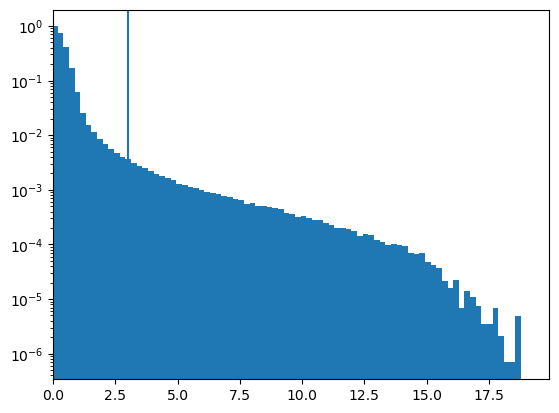

In [8]:
plt.hist(HI_cube.unmasked_data[limz[0]:limy[1],limy[0]:limy[1],limx[0]:limx[1]].to_value().flatten()*1000, bins=100, density=True)
plt.yscale('log')
plt.xlim(0,)
plt.axvline(3)

In [7]:
#define isoleves in mJy/beam
#isolevels = np.array([1.5, 2.5, 3.5, 6]) #hcg91
isolevels = np.array([3, 3.5, 4, 4.5, 5, 6, 7, 8, 9, 10, 12.5, 15]) #hcg16
#isolevels = np.array([1.5, 3.5, 6.5, 11]) #hcg31
#isolevels = np.array([3, 8, 13, 17, 21]) #hcg90 *1000

In [8]:
ralim = HI_cube.spatial_coordinate_map[1][0,:][limx][::int(np.sign(cubehead["CDELT1"]))]
ramean = np.mean(ralim)
declim = HI_cube.spatial_coordinate_map[0][:,0][limy][::int(np.sign(cubehead["CDELT2"]))]
decmean = np.mean(declim)
vlim = HI_cube.spectral_axis[limz][::int(np.sign(dv))]
vmean = np.mean(vlim).to('km/s').to_value()

In [9]:
# create cropped array and transform units to mJy/beam
HI_cube = HI_cube.unmasked_data[limz[0]:limz[1]+1,limy[0]:limy[1]+1,limx[0]:limx[1]+1].to(u.mJy/u.beam).to_value()
# Slice the data, transpose to (ra,dec,v) and flip axes if needed (see if step in FITS header is + or -)
HI_cube = c3.transpose(HI_cube, (dra,ddec,dv))

In [10]:
HI_cube = HI_cube/rms

In [11]:
print(HI_cube.shape)

(220, 220, 133)


In [ ]:
c = '0 0 1'
# HCG31 all from LVM et al. (2005)
gals = {'HCG31a':{'v':4090,'col':c},
       'HCG31b':{'v':4122,'col':c},
       'HCG31c':{'v':3984,'col':c},
        'HCG31g':{'v':4005,'col':c},
        'HCG31q':{'v':4090,'col':c}
       }

In [12]:
c = '0 0 1'
# HCG16 from Hickson 1992
gals = {'HCG16a':{'v':4152,'col':c},
       'HCG16b':{'v':3977,'col':c},
       'HCG16c':{'v':3851,'col':c},
        'HCG16d':{'v':3847,'col':c},
        'NGC848':{'v':4001, 'col':c}
       }

In [ ]:
c = '0 0 1'
# HCG91 from Hickson 1992
gals = {'HCG91a':{'v':6832,'col':c},
       'HCG91b':{'v':7196,'col':c},
       'HCG91c':{'v':7319,'col':c},
        'HCG91d':{'v':7195,'col':c}
       }

In [13]:
for (k,gal) in enumerate(gals.keys()):

    # Go from RA/Dec -> rescaled pixel space !
    coords = SkyCoord.from_name(gal)
    #coords = SkyCoord(gals[gal]['ra'], gals[gal]['dec'])
    #pixcrd = coords.to_pixel(w,1)
    
    coords.ra.deg = (coords.ra.deg-ramean.to_value())*np.cos(np.radians(declim[0]))*3600
    coords.dec.deg = (coords.dec.deg-decmean.to_value())*3600.

    gals[gal]['coord'] = np.array([coords.ra.deg, coords.dec.deg, gals[gal]['v']-vmean])

print(gals)

{'HCG16a': {'v': 4152, 'col': '0 0 1', 'coord': array([-491.35572723,  363.71505096,  303.48593297])}, 'HCG16b': {'v': 3977, 'col': '0 0 1', 'coord': array([-546.78369618,  374.01966507,  128.48593297])}, 'HCG16c': {'v': 3851, 'col': '0 0 1', 'coord': array([-285.46417599,  326.90145096,    2.48593297])}, 'HCG16d': {'v': 3847, 'col': '0 0 1', 'coord': array([-223.42160317,  191.34345096,   -1.51406703])}, 'NGC848': {'v': 4001, 'col': '0 0 1', 'coord': array([ 289.11702925, -302.41675998,  152.48593297])}}


In [14]:
coords = np.array([ralim, declim, vlim])
coords

array([[ 3.23056917e+01,  3.26769125e+01],
       [-1.04194513e+01, -1.00544507e+01],
       [ 3.48462822e+06,  4.21239991e+06]])

In [15]:
color = c3.create_colormap('magma', isolevels)

In [16]:
meta = {'generator':'create_x3d python module',
       'creator':'Name Surname',
       'title':cubehead['OBJECT'],
        'numberofelements':f'{len(isolevels)} layers', 
        'description':'HI data cube of %s'%cubehead['OBJECT']
       } #{len(gals)} galaxies',

In [32]:
import importlib
importlib.reload(c3)

<module 'cube_x3d' from 'c:\\Users\\ixaka\\Documents\\Visualization\\cube_x3d\\cube_x3d.py'>

In [17]:
x3dname = 'HCG16_intube1.x3d'

In [25]:
file = c3.write_x3d('./cube_x3d/examples/%s'%x3dname, delta_arcsec, header=cubehead,
                    coords=coords, units=['mJy/beam', 'arcsec', 'arcsec', 'km/s'],
                     meta=meta, picking=False)

#also need html.func_pick() if picking=True

[[-657.17902714    0.          657.17902714]
 [-657.00109479    0.          657.00109479]
 [-363.88584205    0.          363.88584205]]


In [26]:
survey = ['DSS2 Blue']
verts = (coords[0,0], coords[0,1], coords[1,0], coords[1,1])
imcol, img_shape, img = c3.get_imcol(position='HCG16', survey=survey, verts=verts,
                                     unit='deg', pixels='4000',
                         coordinates='J2000',grid=True, gridlabels=True)

In [43]:
po = np.array([[100,100,100],[120,100,100],[150,120,100],[150,120,120],[140,110,140]])
centr1 = np.array([[0,0,100],[0,20,100], [0,100,100]])
centr2 = np.array([[0,0,-100],[0,-20,-100], [0,-100,-100]])
centr1 = np.array([[40,0,100],[0,20,100], [0,100,100]])
centr2 = np.array([[0,0,-100],[0,-20,-100], [50,-100,-100]])
size = np.array([[5,12,7],[6,6,10], [8,10,30]])

In [27]:
file.make_layers(HI_cube, isolevels, [color])
file.make_outline()
file.make_galaxies(gals=gals, labels=True)
file.make_image2d(imcol=imcol, img_shape=img_shape)
#file.make_markers(geom='tube', points=po, shape=5)
#file.make_markers(centr1, radius=size)
#file.make_markers(centr2, radius=8, box=False, col='1 0 1')
file.make_ticklines()
file.make_animation()
file.make_labels(gals=gals, axlab='both') #gals=gals
# html.func_scalev(axes) should be same as axlab, not func_axes() though.
file.close()

In [28]:
tabtitle = 'HCG16'
pagetitle = 'HCG16 interactive HI datacube with X3D'
# add in desc for 2d image: <br>\n\t Background image: {survey}
#desc = f"Object: {cubehead['OBJECT']}.<t> Telescope: {cubehead['TELESCOP']}. RestFreq = {cubehead['RESTFREQ']/1e6:.4f} MHz.<br>\n\t Center: (RA,Dec,V)=({np.round(ramean,5)}, {np.round(decmean,5)}, {np.round(vmean,3)} km/s)"

In [29]:
colmaps = ['magma', 'CMRmap', 'inferno', 'plasma', 'viridis', 'Greys',
           'Blues', 'OrRd', 'PuRd', 'Reds', 'Spectral', 'Wistia',
          'YlGn', 'YlOrRd', 'afmhot', 'autumn', 'cool', 'coolwarm',
          'copper', 'cubehelix', 'flag', 'gist_earth', 'gist_heat',
          'gist_ncar', 'gist_stern', 'gnuplot', 'gnuplot2', 'hot',
          'nipy_spectral', 'prism', 'winter', 'Paired']
#colmaps = plt.colormaps()

In [33]:
html = c3.write_html('./cube_x3d/examples/%s.html'%x3dname.split('.')[0], units=['sigma', 'arcsec', 'arcsec', 'km/s'],
                     tabtitle=tabtitle, pagetitle=pagetitle,
                     description=None)

In [34]:
html.func_layers([isolevels])
html.func_galaxies(gals)
html.func_gallab()
html.func_grids()
html.func_axes('both')
#html.func_pick() #for coordinate picking
html.func_animation()
#html.func_tubes(ntubes=len(po)-1)
#html.func_markers(nbox=len(centr1), nsph=len(centr2))
html.start_x3d()
html.viewpoints(file.diff_coords[:,2])
html.close_x3d(x3dname)
html.buttons([isolevels], [color], colormaps=colmaps, hide2d=True, scalev=True, move2d=True, background=True)
html.func_tubes() #always after buttons
#func_move2dimage, func_colormaps and func_scalev must always go after buttons
html.func_background()
html.func_galsize(gals)
html.func_image2d()
html.func_colormaps([isolevels])
html.func_scalev(gals=gals, axes='both', coords=file.diff_coords, move2d=True) #gals , points=po
html.func_move2dimage(file.diff_coords[2,2], file.real_coords[2,2])
html.close_html()